<a href="https://www.kaggle.com/code/qayyimsyahmi/predicting-absenteesim?scriptVersionId=141201035" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# Import relevant modules for preprocessing the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/absenteeism-at-work-uci-ml-repositiory/Absenteeism_at_work.csv


# Business Case Study: Predicting the onset of absenteesim
### The objective of this study is to assist businesses in identifying early signs of absenteeism (for a specific number of hours within a workday)
### The framework follows a multivariate prediction approach and involves several processes detailed below, in the following order:
1. Loading the dataset in pandas
2. Dealing with categorical data (mapping arbitary numbers or dummy variables)
3. Identfying the "cut-off" point for excessive absenteesim based on statistical analysis
4. Scaling non-categorical predictors
5. Splitting datasets to avoid overfitting
6. Implementing logistic regression with sklearn on the training dataset
7. Interpreting the logistics regression results and make necessary changes to step 2 - 7
8. Applying logistic regression with sklearn on testing dataset
9. Export the model by creating modules
10. Test the modules by passing through the modules as arguments in a custom-made class and functions
11. Extra: Analyzing the Predicted Outputs

Do note that the exercise here have gone multiple iterations therefore some parts of the code are marked as "markdown" as it no longer serve any purpose for the framework except for inspecting how the old code works

# Pre-processing

In [2]:
# read the data in csv

df = pd.read_csv('/kaggle/input/absenteeism-at-work-uci-ml-repositiory/Absenteeism_at_work.csv', delimiter = ';')
df

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,...,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239.554,...,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239.554,...,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,11,14,7,3,1,289,36,13,33,264.604,...,0,1,2,1,0,1,90,172,30,8
736,1,11,7,3,1,235,11,14,37,264.604,...,0,3,1,0,0,1,88,172,29,4
737,4,0,0,3,1,118,14,13,40,271.219,...,0,1,1,1,0,8,98,170,34,0
738,8,0,0,4,2,231,35,14,39,271.219,...,0,1,2,1,0,2,100,170,35,0


## Understanding and describing the dataset

In [3]:
# Before proceed into manipulating the data in a format we want, we must first copy the dataset

df_new = df.copy()

In [4]:
# Let's quickly go through the rows as well as the columns of the dataset
# The view is limited, where only top 5 and bottom 5 are shown (the middle is deprecated)
# To fix this, we can set our max view to 'None' to both rows and columns

pd.options.display.max_rows = None
pd.options.display.max_columns = None

# Viewing the dataset once more

df_new

# Reset the view
pd.options.display.max_rows = 10
pd.options.display.max_columns = None

In [5]:
# Data Types

df_new.info()

# Looks like the rest of the columns are ints, except for  daily work load average (float)
# It is also observed that none of the features or attribites here containing missing data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               740 non-null    int64  
 1   Reason for absence               740 non-null    int64  
 2   Month of absence                 740 non-null    int64  
 3   Day of the week                  740 non-null    int64  
 4   Seasons                          740 non-null    int64  
 5   Transportation expense           740 non-null    int64  
 6   Distance from Residence to Work  740 non-null    int64  
 7   Service time                     740 non-null    int64  
 8   Age                              740 non-null    int64  
 9   Work load Average/day            740 non-null    float64
 10  Hit target                       740 non-null    int64  
 11  Disciplinary failure             740 non-null    int64  
 12  Education             

## Attributes or Features selection and manipulation

### ID

In [6]:
# Now, let's first look at the feature ID
# ID is a categorical data type, where the level of measurement is nominal
# This means it is the ID assign to each of the employee to designate employee identification
# But this will not have any effect or whatsoever to the analyses
# Therefore dropping the ID column is crucial or otherwise it can create issue to the model

df_new = df_new.drop(['ID'], axis = 1)
df_new

,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,26,7,3,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,4
1,0,7,3,1,118,13,18,50,239.554,97,1,1,1,1,0,0,98,178,31,0
2,23,7,4,1,179,51,18,38,239.554,97,0,1,0,1,0,0,89,170,31,2
3,7,7,5,1,279,5,14,39,239.554,97,0,1,2,1,1,0,68,168,24,4
4,23,7,5,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,14,7,3,1,289,36,13,33,264.604,93,0,1,2,1,0,1,90,172,30,8
736,11,7,3,1,235,11,14,37,264.604,93,0,3,1,0,0,1,88,172,29,4
737,0,0,3,1,118,14,13,40,271.219,95,0,1,1,1,0,8,98,170,34,0
738,0,0,4,2,231,35,14,39,271.219,95,0,1,2,1,0,2,100,170,35,0


### Reason for Absence column

In [7]:
# Next, let's dive into Reason for Absence
# We don't know what the numbers meant, but what we can do now is to list out the numbers assigned to all rows of the dataset

print(df_new['Reason for absence'].max()) # The maximum number for this column is 28
print(df_new['Reason for absence'].median()) # The middle mumber for this column is 23 (this can be applied as this column is integer types)
print(df_new['Reason for absence'].min()) # The minimum number for this column is 0

# From min and max, we can make a guess how many elements are there for Reason for Absence
# There are 29 (0 - 28) integers that are being represented in this column
# But, is this actually true? Let's use len() method to compare

print(len(pd.unique(df_new['Reason for absence'])))

# Looks like there are 28 elements listed (missing 1)
# Also, which are the 28 reasons for absence that these integers are used to substitute in this column mean?
# In other words, the values here must have represent something...

28
23.0
0
28


In [8]:
# Using pandas to extract all of the elements from the dataframe
# Extract all the elements in the array

print(pd.unique(df_new['Reason for absence']))

# Sort them from lowest to highest

df_absence = df_new.sort_values(['Reason for absence'])
print(pd.unique(df_absence['Reason for absence']))

# Here, we can see that 20 is missing...

[26  0 23  7 22 19  1 11 14 21 10 13 28 18 25 24  6 27 17  8 12  5  9 15
  4  3  2 16]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24
 25 26 27 28]


In [9]:
# Using numpy to take the array for this column to transform and extract all of the elements from the dataframe and sort the values
# Extract the elements in the array

arr = np.array(df_new['Reason for absence'].unique())

# Sort them from lowest to highest

print(np.sort(arr))

# Here, we can see that 20 is missing too as well

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24
 25 26 27 28]


#### One-Hot Encodding

In [10]:
# Let's go back to our initial question on what does all these integers actually means?
# According the International Statistical Classification of Diseases and Related Health Problems 10th Revision, these values represents specific type of diseases
# TLDR; 1 - 14: represents common sickness, 15 - 17: complications that could result from pregnancy, 18 - 21: Related to poisoning, 22 - 28: Consultation, follow ups, (light reasons for absence) etc.
# Therefore, we can consider the data types to be categorical and nominal in nature

# In saying that, we must bring numneric meaning into these values for our analyses
# One of the easiest method to do so is to create dummy variables for these categorical types
# Hence, we know that each of the categories for reason for absence will only be filled once by the employee
# The employee is absence from work because of one particular reasons only...


# Assing a new dataframe that contains dummy data

reason_dummy = pd.get_dummies(df_new['Reason for absence'])

print(reason_dummy)

# So each of the rows would have 1 occupied at any of the column in Reason for Absence

     0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  \
0     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1     1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
3     0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   
4     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
735   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   
736   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   
737   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
738   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
739   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

     18  19  21  22  23  24  25  26  27  28  
0    

In [11]:
# To check that 1 is populated and non is missing

sum = reason_dummy.sum(axis = 1)
print(sum)

# All of the indexes have been occupied by 1s

check_1 = sum.unique()
print(check_1)

# Here, we can already verify 1 has been occupied

0      1
1      1
2      1
3      1
4      1
      ..
735    1
736    1
737    1
738    1
739    1
Length: 740, dtype: int64
[1]


In [12]:
# Next, we need to drop the first column from this new dataframe 
# The reason is because we want to prevent multi-collinearity
# Dropping the first column will act as a baseline while the rest are represented in comparison to this

reason_dummy = pd.get_dummies(df_new['Reason for absence'], drop_first = True)

# Re-check whether the column '0' has been dropped

print(reason_dummy)

     1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  18  \
0     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
3     0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   
4     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
735   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   
736   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   
737   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
738   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
739   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

     19  21  22  23  24  25  26  27  28  
0     0  

In [13]:
# The next step now is to replace the df_new datframe containing 'Reasons for absence' column with the encodded ones above

print(df_new.columns.values)

# We need to 'merge' the reason_dummy with the df_new dataframe
# But, instead of dropping, we will replace with a new dataset but with much larger size (column 1 - column 28)
# In this situation, we can group the variables and re-organize our data
# We know that, in principle, we have 4 types of reasons for absence (common sickness, complications from pregnancy, poisoning related and light reasons
#  1- 14: represents common sickness
# 15 - 17: complications that could result from pregnancy
# 18 - 21: Related to poisoning
# 22 - 28: Consultation, follow ups, (light reasons for absence) etc

# We need to 'split' reason_dummy into 4 columns corresponding to only 4 types of absence
# And within these reasons, any of the rows must have 1 as the reason for absence

reason_type_1 = reason_dummy.loc[:,1:14].max(axis =1)
reason_type_2 = reason_dummy.loc[:,15:17].max(axis =1)
reason_type_3 = reason_dummy.loc[:,18:21].max(axis =1)
reason_type_4 = reason_dummy.loc[:,22:28].max(axis =1)

# Do note that applying max will return these variables or attributes as Pandas Series instead of Pandas DataFrame

['Reason for absence' 'Month of absence' 'Day of the week' 'Seasons'
 'Transportation expense' 'Distance from Residence to Work' 'Service time'
 'Age' 'Work load Average/day ' 'Hit target' 'Disciplinary failure'
 'Education' 'Son' 'Social drinker' 'Social smoker' 'Pet' 'Weight'
 'Height' 'Body mass index' 'Absenteeism time in hours']


In [14]:
# Dropping the Reasons for absence original column in df_new

df_new = df_new.drop(['Reason for absence'], axis = 1)

#### Combining the reasons type with df_new dataframe

In [15]:
# Use concat to concatenate pandas series (reason_types) along a particular axis

df_new = pd.concat([df_new, reason_type_1, reason_type_2, reason_type_3, reason_type_4], axis = 1)

In [16]:
# Next, we need to rename these columns

print(df_new.columns.values)

df_new.columns = ['Month of absence' ,'Day of the week' ,'Seasons' ,'Transportation expense'
 ,'Distance from Residence to Work' ,'Service time' ,'Age'
 ,'Work load Average/day ' ,'Hit target' ,'Disciplinary failure' ,'Education'
 ,'Son' ,'Social drinker' ,'Social smoker' ,'Pet' ,'Weight' ,'Height'
 ,'Body mass index' ,'Absenteeism time in hours', 'Reason_1', 'Reason_2', 'Reason_3', 'Reason_4']

['Month of absence' 'Day of the week' 'Seasons' 'Transportation expense'
 'Distance from Residence to Work' 'Service time' 'Age'
 'Work load Average/day ' 'Hit target' 'Disciplinary failure' 'Education'
 'Son' 'Social drinker' 'Social smoker' 'Pet' 'Weight' 'Height'
 'Body mass index' 'Absenteeism time in hours' 0 1 2 3]


In [17]:
# Re-order the columns to make the Reasons to appear on the left of dataframe
df_new = df_new[['Reason_1', 'Reason_2', 'Reason_3', 'Reason_4'
 ,'Month of absence' ,'Day of the week' ,'Seasons' ,'Transportation expense'
 ,'Distance from Residence to Work' ,'Service time' ,'Age'
 ,'Work load Average/day ' ,'Hit target' ,'Disciplinary failure' ,'Education'
 ,'Son' ,'Social drinker' ,'Social smoker' ,'Pet' ,'Weight' ,'Height'
 ,'Body mass index' ,'Absenteeism time in hours']]

In [18]:
df_new.head()

,Reason_1,Reason_2,Reason_3,Reason_4,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,0,0,0,1,7,3,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,4
1,0,0,0,0,7,3,1,118,13,18,50,239.554,97,1,1,1,1,0,0,98,178,31,0
2,0,0,0,1,7,4,1,179,51,18,38,239.554,97,0,1,0,1,0,0,89,170,31,2
3,1,0,0,0,7,5,1,279,5,14,39,239.554,97,0,1,2,1,1,0,68,168,24,4
4,0,0,0,1,7,5,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,2


### Checkpoint

In [19]:
df_new_reason = df_new.copy()

### Date Related

In [20]:
# let's take deeper look at the columns related to date..

month = df_new_reason['Month of absence']
day = df_new_reason['Day of the week']
seasons = df_new_reason['Seasons']

month_arr = np.array(df_new_reason['Month of absence'].unique())
print(np.sort(month_arr))

day_arr =np.array(df_new_reason['Day of the week'].unique())
print(np.sort(day_arr))

seasons_arr =np.array(df_new_reason['Seasons'].unique())
print(np.sort(seasons_arr))

# the arrays below shows that these values appear to be ordinal and categorical data type
# the next question is, how useful these features will be for our analyses

[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
[2 3 4 5 6]
[1 2 3 4]


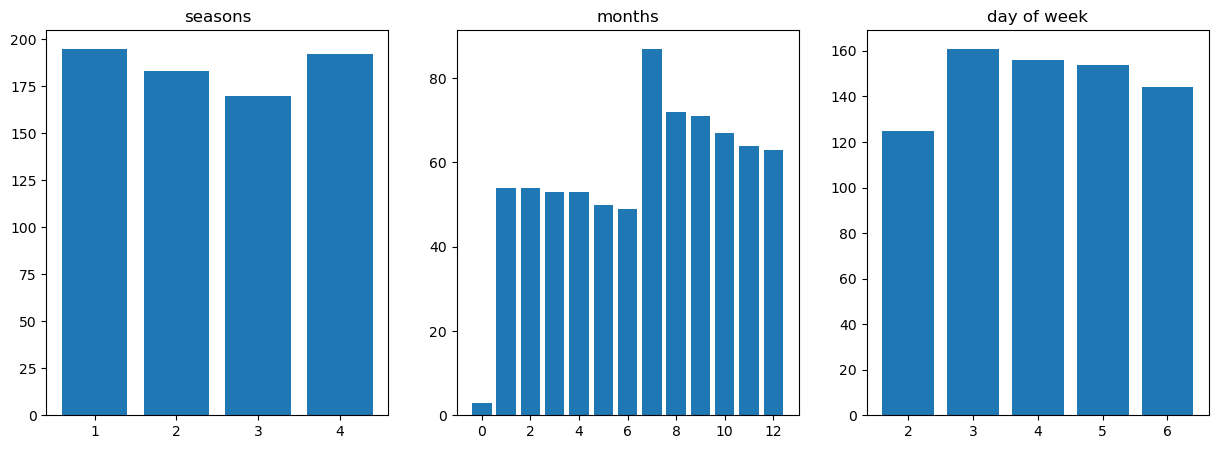

In [21]:
# let's find out how are these values for each of these columns are distributed in the dataset 
# plotting a simply bar chart for these categorical types of data

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,5))

# seasons
ax1.bar(seasons_arr, seasons.value_counts())
ax1.set_title('seasons')

# month
ax2.bar(month_arr, month.value_counts())
ax2.set_title('months')

# dayofweek
ax3.bar(day_arr, day.value_counts())
ax3.set_title('day of week')

fig.show()

# observing the counts of the occurrance shows a very unique distribution
# The attributes related to seasons indicate a balanced distribution throughout the dataset.
# As for months, it is observed that the highest peak is July. Surprisingly, 0 are also included here as well
# As for day of the week, Tuesday (3) records the highest count, followed by Monday (2) which has the lowest count among all weekdays

# for now, let's keep this attribute as it is as it might be worth exploring later

In [22]:
df_new_reason.columns.values

array(['Reason_1', 'Reason_2', 'Reason_3', 'Reason_4', 'Month of absence',
       'Day of the week', 'Seasons', 'Transportation expense',
       'Distance from Residence to Work', 'Service time', 'Age',
       'Work load Average/day ', 'Hit target', 'Disciplinary failure',
       'Education', 'Son', 'Social drinker', 'Social smoker', 'Pet',
       'Weight', 'Height', 'Body mass index', 'Absenteeism time in hours'],
      dtype=object)

In [23]:
### Transportation Expenses, Distance to Work, Service time, Age, Work load Average/day, Height, Weight,  Body Mass Index, Service Time

# Most of the columns listed here will not be manipulated since it already convey the actual meaning in their real terms
# Let's take a look about their data types and how can we explain each of these terms

# Transporation Expenses
# They are costs related to business travel
# In this case, they are measured in dollars ($) and assumed to have been rounded up or rounded down
# Hence why the data type is in integer format
print(type(df_new_reason['Transportation expense'][0]))

# Distance from Residence to Work
# The distance that the employee must travel to work
# They are represented in kilometers and again, assumed to have been rounded up or rounded down
# Hence why the data type is in integer format
print(type(df_new_reason['Distance from Residence to Work'][0]))

# Age
# The age of the employee in years
# Same as before...
print(type(df_new_reason['Age'][0]))

# Service time
# They represents has the employee been serving the company
print(type(df_new_reason['Service time']))

# Work load Average/day
# The average amount of time spent working per day
# They are represented in minutes
# Unlike the above, it is a float type
print(type(df_new_reason['Work load Average/day '][0]))

# Body Mass Index or BMI
# Logically, people who weigh above the norm for their height often have an additional reason for being absent from work
# That's why we should keep these numbers for analyses
print(type(df_new_reason['Body mass index'][0]))

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'pandas.core.series.Series'>
<class 'numpy.float64'>
<class 'numpy.int64'>


### Height and Weight

In [24]:
# Height and Weight
# This feature has been explained by the other feature, BMI
# Therefore, we we won't be needing this feature as it will become redundant in our analyses
df_new_reason = df_new_reason.drop(['Height'], axis = 1)
df_new_reason = df_new_reason.drop(['Weight'], axis = 1)

### Checkpoint

In [25]:
df_var_ex = df_new_reason.copy()

### Education

In [26]:
# Education represents a categorical data type where those numeric number does not have numeric meaning
# In fact, based on the given information, there are only 1s, 2s, 3s and 4s

df_var_ex['Education'].unique()

array([1, 3, 2, 4])

In [27]:
# Based on the domain knowledge, it is told that 1 = high school education, 2 = graduate education, 3 = postgraduate & 4 = master or doctor
# Let's count the distribution of these labels

df_var_ex['Education'].value_counts()

# Basically, we have <600 compromises those who only finishes high school and top 100 to those with higher education background

1    611
3     79
2     46
4      4
Name: Education, dtype: int64

#### Mapping categorical label to binary (0, 1)

In [28]:
# Here we have a choice, either 
# 1. we map the Education into 4 classes and create even more dummy variables
# OR
# 2. we only map them into 2 classes (those with only high school qualification and those with higher education)
# For the sake of simplicity, we will choose option 2.

# In this case, we need to map education label 1s to 0 while the rest to 1

df_var_ex['Education'] = df_var_ex['Education'].map({1:0, 2:1, 3:1, 4:1})

df_var_ex['Education'].unique()

array([0, 1])

### What about the rest of the features?

In [29]:
# at the moment, we can retain the remaining column that we haven't displayed or discussed here
# after a quick visual inspection of these features, we can safely say that there is no immediate need for preprocessing

### Checkpoint

In [30]:
df_preprocessed = df_var_ex.copy()

## Exporting the dataset

In [31]:
df_preprocessed.to_csv('Absenteeism_preprocessed.csv', index = False)

# Logistic Regression Modelling

## Import the relevant packages

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load the dataset

In [33]:
data_p = pd.read_csv('Absenteeism_preprocessed.csv')

In [34]:
data_p.head()

,Reason_1,Reason_2,Reason_3,Reason_4,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Body mass index,Absenteeism time in hours
0,0,0,0,1,7,3,1,289,36,13,33,239.554,97,0,0,2,1,0,1,30,4
1,0,0,0,0,7,3,1,118,13,18,50,239.554,97,1,0,1,1,0,0,31,0
2,0,0,0,1,7,4,1,179,51,18,38,239.554,97,0,0,0,1,0,0,31,2
3,1,0,0,0,7,5,1,279,5,14,39,239.554,97,0,0,2,1,1,0,24,4
4,0,0,0,1,7,5,1,289,36,13,33,239.554,97,0,0,2,1,0,1,30,2


## Create Targets

Text(0, 0.5, 'Count')

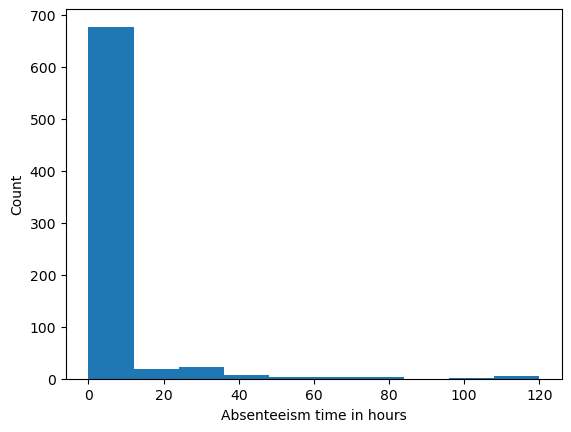

In [35]:
# Before we can assign our targets in the column 'Absenteeism Time in Hours', we must first define the cut off line
# Let's look at the distribution plot of this column

plt.hist(data_p['Absenteeism time in hours'])
plt.xlabel('Absenteeism time in hours')
plt.ylabel('Count')
           
# As observed below, the data is heavily skewed on the right, which means its not normally distributed

In [36]:
# Mean, Median, Max, Min

print(data_p['Absenteeism time in hours'].mean())
print(data_p['Absenteeism time in hours'].median())
print(data_p['Absenteeism time in hours'].min())
print(data_p['Absenteeism time in hours'].max())

# In some extreme cases, some employee has recorded 120 hours of not being available for work

6.924324324324324
3.0
0
120


In [37]:
# Describing the dataset

data_p['Absenteeism time in hours'].describe(include='all')

count    740.000000
mean       6.924324
std       13.330998
min        0.000000
25%        2.000000
50%        3.000000
75%        8.000000
max      120.000000
Name: Absenteeism time in hours, dtype: float64

In [38]:
# We would need to classify the abseenteeism by moderate or excessive
# A naive approach would be to classify them based on the median
# This is because that using median as a cut off line is numerically stable at most of the time in ML
# It is also why we need median because the dataset will be balance in this way and we would not want any biases in our prediction

median = data_p['Absenteeism time in hours'].median()

# In this way, any hours in this column where it is below can be considered as 'Moderately Absent'
# Or anything above is 'Excessively Absent'

In [39]:
# Assigning the numbers using np.where

targets = np.where(data_p['Absenteeism time in hours'] > median, 1, 0)

data_p['Absenteeism time in hours'] = targets

In [40]:
# To check whether the dataset is 'balanced'

targets.sum() / targets.shape[0]

# 1s consist about 45.5% out of all 700 rows of results
# It is relatively balanced

0.4581081081081081

## Checkpoint

In [41]:
# To assign this new variables containing 1s and 0s into the data frame

data_with_targets = data_p.copy()
data_with_targets.head()

,Reason_1,Reason_2,Reason_3,Reason_4,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Body mass index,Absenteeism time in hours
0,0,0,0,1,7,3,1,289,36,13,33,239.554,97,0,0,2,1,0,1,30,1
1,0,0,0,0,7,3,1,118,13,18,50,239.554,97,1,0,1,1,0,0,31,0
2,0,0,0,1,7,4,1,179,51,18,38,239.554,97,0,0,0,1,0,0,31,0
3,1,0,0,0,7,5,1,279,5,14,39,239.554,97,0,0,2,1,1,0,24,1
4,0,0,0,1,7,5,1,289,36,13,33,239.554,97,0,0,2,1,0,1,30,0


In [42]:
# Renaming the target column

data_with_targets['Excessive Absenteeism'] = data_with_targets['Absenteeism time in hours']

In [43]:
# Dropping the initial column
# data_with_targets = data_with_targets.drop(['Absenteeism time in hours'], axis = 1)

## On the 2nd iteration, we will drop the columns that we have identified when interpreting the coefficients
data_with_targets = data_with_targets.drop(['Absenteeism time in hours', 'Work load Average/day ', 'Education', 'Age', 'Hit target', 'Reason_2'], axis = 1)

## Selecting the Inputs

In [44]:
# Using iloc to only select all of the other features besides the target and assign them as inputs

data_with_inputs_unscaled = data_with_targets.iloc[:,:-1]

In [45]:
# Re-checking the inputs

data_with_inputs_unscaled

,Reason_1,Reason_3,Reason_4,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Disciplinary failure,Son,Social drinker,Social smoker,Pet,Body mass index
0,0,0,1,7,3,1,289,36,13,0,2,1,0,1,30
1,0,0,0,7,3,1,118,13,18,1,1,1,0,0,31
2,0,0,1,7,4,1,179,51,18,0,0,1,0,0,31
3,1,0,0,7,5,1,279,5,14,0,2,1,1,0,24
4,0,0,1,7,5,1,289,36,13,0,2,1,0,1,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,1,0,0,7,3,1,289,36,13,0,2,1,0,1,30
736,1,0,0,7,3,1,235,11,14,0,1,0,0,1,29
737,0,0,0,0,3,1,118,14,13,0,1,1,0,8,34
738,0,0,0,0,4,2,231,35,14,0,2,1,0,2,35


In [46]:
# Split the dataset target into only containing the targets

data_with_targets = data_with_targets['Excessive Absenteeism']

## Normalizing or Standardizing the inputs

In [47]:
# Import sklearn standard scaler

from sklearn.preprocessing import StandardScaler

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [48]:
# Create the scalar object

abs_scaler = StandardScaler()

In [49]:
# Fit the inputs (and calculate the mean and std. dev. feature wise)

# abs_scaler.fit(data_with_inputs_unscaled)

# Transform the inputs

# data_with_inputs_scaled = abs_scaler.transform(data_with_inputs_unscaled)


## 2nd iteration: Normally we will scale all of the features here but since we ran into an issues to interpret the odds for dummy variables, we will momentarily disable this feature and instead we will the custom code or custom class below:
## Import the libraries needed for the custom scaler:

from sklearn.base import BaseEstimator, TransformerMixin

# Create the Custom Scaler class

class CustomScaler(BaseEstimator,TransformerMixin): 
    
    # init or what information we need to declare a CustomScaler object
    # and what is calculated/declared as we do
    
    def __init__(self,columns):
        
        # scaler is nothing but a Standard Scaler object
        self.scaler = StandardScaler()
        # with some columns 'twist'
        self.columns = columns
        self.mean_ = None
        self.var_ = None
        
    
    # the fit method, which, again based on StandardScale
    
    def fit(self, X, y=None):
        self.scaler.fit(X[self.columns], y)
        self.mean_ = np.mean(X[self.columns])
        self.var_ = np.var(X[self.columns])
        return self
    
    # the transform method which does the actual scaling

    def transform(self, X, y=None, copy=None):
        
        # record the initial order of the columns
        init_col_order = X.columns
        
        # scale all features that you chose when creating the instance of the class
        X_scaled = pd.DataFrame(self.scaler.transform(X[self.columns]), columns=self.columns)
        
        # declare a variable containing all information that was not scaled
        X_not_scaled = X.loc[:,~X.columns.isin(self.columns)]
        
        # return a data frame which contains all scaled features and all 'not scaled' features
        # use the original order (that you recorded in the beginning)
        return pd.concat([X_not_scaled, X_scaled], axis=1)[init_col_order]

In [50]:
# Re-check the columns that the dataframe has

data_with_inputs_unscaled.columns.values

array(['Reason_1', 'Reason_3', 'Reason_4', 'Month of absence',
       'Day of the week', 'Seasons', 'Transportation expense',
       'Distance from Residence to Work', 'Service time',
       'Disciplinary failure', 'Son', 'Social drinker', 'Social smoker',
       'Pet', 'Body mass index'], dtype=object)

In [51]:
# Choose the columns to scale and augment this code (copy above)
# Retain the columns we want for scale and omit those with dummy variables (Reasons and Education)

## On the 2nd iteration, we will use comprehension list in order to sort our columns to scale seamlessly
## Therefore, we will reserve the code below and instead only declare columns_to_omit

#columns_to_scale = ['Month of absence',
       #'Day of the week', 'Seasons', 'Transportation expense',
       #'Distance from Residence to Work', 'Service time', 'Son',
       #'Pet', 'Body mass index']
    
# select the columns to omit
columns_to_omit = ['Reason_1', 'Reason_2', 'Reason_3', 'Reason_4','Education', 'Social drinker', 'Social smoker', 'Disciplinary failure']

# Create the columns to scale, based on the columns to omit
# Use list comprehension to iterate over the list
columns_to_scale = [x for x in data_with_inputs_unscaled.columns.values if x not in columns_to_omit]

In [52]:
# Declare a scaler object, specifying the columns you want to scale
abs_scaler = CustomScaler(columns_to_scale)

In [53]:
# Fit the inputs (and calculate the mean and std. dev. feature wise)
abs_scaler.fit(data_with_inputs_unscaled)

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


CustomScaler(columns=['Month of absence', 'Day of the week', 'Seasons',
                      'Transportation expense',
                      'Distance from Residence to Work', 'Service time', 'Son',
                      'Pet', 'Body mass index'])

In [54]:
# Transform the data
data_with_inputs_scaled = abs_scaler.transform(data_with_inputs_unscaled)

In [55]:
# Re-check the inputs

print(data_with_inputs_scaled)

# shape

print('\n',data_with_inputs_scaled.shape)

     Reason_1  Reason_3  Reason_4  Month of absence  Day of the week  \
0           0         0         1          0.196763        -0.643947   
1           0         0         0          0.196763        -0.643947   
2           0         0         1          0.196763         0.059924   
3           1         0         0          0.196763         0.763796   
4           0         0         1          0.196763         0.763796   
..        ...       ...       ...               ...              ...   
735         1         0         0          0.196763        -0.643947   
736         1         0         0          0.196763        -0.643947   
737         0         0         0         -1.841698        -0.643947   
738         0         0         0         -1.841698         0.059924   
739         0         0         0         -1.841698         1.467667   

      Seasons  Transportation expense  Distance from Residence to Work  \
0   -1.390175                1.011408                        

## Splitting the dataset and shuffling

In [56]:
# Import the relevant package
from sklearn.model_selection import train_test_split

In [57]:
# Split the dataset to overcome overfitting, with 20-80 split with shuffling enabled
# We will stick to random_state

x_train, x_test, y_train, y_test = train_test_split(data_with_inputs_scaled, data_with_targets, train_size = 0.8, random_state = 20, shuffle = True)

In [58]:
# Shpae of the training dataset

print(x_train.shape)
print(y_train.shape)

(592, 15)
(592,)


In [59]:
# Shpae of the testing dataset

print(x_test.shape)
print(y_test.shape)

(148, 15)
(148,)


# Logistic Regression

In [60]:
# Import sklearn modules

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

## Training the model

In [61]:
# Logistic Regression

log_reg = LogisticRegression()

In [62]:
# Fit the scaled inputs and targets

log_reg.fit(x_train, y_train)

LogisticRegression()

In [63]:
# Predict the outputs using scaled inputs

log_reg.predict(x_train)

array([1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,

## Check Accuracy

In [64]:
# Check the accuracy
# There are 2 ways to check the accuracy
# Use LogisticRegression.score() method that returns the mean accuracy

print(log_reg.score(x_train, y_train))

# Manually compare the arrays of predicted outputs with the targets
print(np.sum(log_reg.predict(x_train) == y_train)/y_train.shape[0])

# The 1st iteration shows that the accuracy is 76.18%
# The 2nd iteration shows that the accuracy is 76.89%

0.7668918918918919
0.7668918918918919


## Finding the intercept and coefficients

In [65]:
# We are now interested to use this model outside of Python
# Logistic Regression model is about determining whats is the intercept and the coefficients

# Intercept
print('intercept:', log_reg.intercept_)

# Coefficients
print('coefficient:', log_reg.coef_)

# Each of these coefficients represents the column or the values from the inputs that we obtain
# Let's refer each of these coefficients to the columns

# Do note that if we access the variable inputs after scaled, we will only get arrays
# That is because sklearn will process any inputs and transform them into arrays
print('\n',data_with_inputs_scaled)

# The alternative to this is to access the unscaled data instead since it is still in dataframe format
print('\n','weights:', data_with_inputs_unscaled.columns.values)

intercept: [-0.79047955]
coefficient: [[ 1.60247324  1.74894462 -0.31981642  0.24664883 -0.16956161 -0.31533187
   0.51269215 -0.11267142 -0.29420012 -2.80269081  0.42351225  0.70739094
   0.4193153  -0.32444001  0.24057738]]

      Reason_1  Reason_3  Reason_4  Month of absence  Day of the week  \
0           0         0         1          0.196763        -0.643947   
1           0         0         0          0.196763        -0.643947   
2           0         0         1          0.196763         0.059924   
3           1         0         0          0.196763         0.763796   
4           0         0         1          0.196763         0.763796   
..        ...       ...       ...               ...              ...   
735         1         0         0          0.196763        -0.643947   
736         1         0         0          0.196763        -0.643947   
737         0         0         0         -1.841698        -0.643947   
738         0         0         0         -1.841698 

In [66]:
# Now let's create a summary table

reg_summary = pd.DataFrame(data_with_inputs_unscaled.columns.values, columns = ['Features'])
reg_summary['Coefficients'] = np.transpose(log_reg.coef_)

reg_summary

,Features,Coefficients
0,Reason_1,1.602473
1,Reason_3,1.748945
2,Reason_4,-0.319816
3,Month of absence,0.246649
4,Day of the week,-0.169562
...,...,...
10,Son,0.423512
11,Social drinker,0.707391
12,Social smoker,0.419315
13,Pet,-0.324440


In [67]:
# Let's insert the Intercept at index = 0

intercept = pd.DataFrame({'Features':'Intercept', 'Coefficients':log_reg.intercept_[0]}, index = [0])

reg_summary = pd.concat([intercept, reg_summary.loc[:]]).reset_index(drop=True)

In [68]:
# Print the summary table again

reg_summary

,Features,Coefficients
0,Intercept,-0.790480
1,Reason_1,1.602473
2,Reason_3,1.748945
3,Reason_4,-0.319816
4,Month of absence,0.246649
...,...,...
11,Son,0.423512
12,Social drinker,0.707391
13,Social smoker,0.419315
14,Pet,-0.324440


## Interpreting the coefficients

In [69]:
# The logistic regression equation follows log expression where the odds that we are predicting for each features are so called log-odds
# To intepret the coefficients, we must find the exponentials for each of these log odds
# This transform the coefficients by exponent the coefficients w.r.t to the log odds

reg_summary['Odds Ratio'] = np.exp(reg_summary['Coefficients'])

In [70]:
# Print the summary table that contains the exponent odds

reg_summary

# Let's sort them in accordance to its increasing Odds Ratio

reg_summary.sort_values('Odds Ratio', ascending = False)

# To better understand what is being shown here, we can see features whose coefficients are closer to 0 aren't particularly important
# Another way to look at it is that coefficients that is closer to 0, if multiplied by any feature value, it will not change 
# In a standardize features, any unit of change must be multiply altogether with the Odds Ratio. The higher the Odds Ratio, the bigger the unit change in reference to the base values
# Thereofre, we will only emphasize features having their coefficients away from 0

# We can consider to drop all Education, Work load Average/day, Hit target, Age from our analyses
# In other words, these features does not make any significant difference at all

## 1st iteration
## This comment was initially made when all features had been scaled for each of them, hence neglect this and please move to the next comment for the next instruction
# As for Reason as the Features, it has been encodded and dummy variables were created as a follow up
# In these all Reasons, we know that we drop the first description for Reason
# Hence the first description in the list of all of the possible reasons, this serves as the base model
# Meaning, the Odds of which Reason_1 is probable is 2.80 times likely than the base case (no reason)
# However, do note that this could only work if we hadn't standardize the dummy variables for the Reasons features, hence making this harder to interpret (please the scaling method)
# This same goes for Education where we also create a dummy variable between 1 and 0 (where initially we had 4 kinds of education)

## 2nd iteration
# We have now noticed a very much more pronounced results for reasons
# Let's recap on the classifcation  Reason_1: represents common sickness, Reason_2: complications that could result from pregnancy, Reason_3: Related to poisoning, Reason_4: Consultation, follow ups, (light reasons for absence) etc.
# Here, we have 5x more likely for the person to be excessively absent when the reason could be due to poisoning
# Another features we can take a look at is Pets, where the base case model is having no Pets. It has a much weaker explanotary power is the odds of excessive absenteeism by having pets is (1-0.70) = 30% lower than not having pets at all
# However, we still have issues intepreting a wider interval and continous data types such as Transportation Expense but we can deduce at having 1.7 times more likely than those spending less to work will become absent for work
# Despite that, we can still use the results below for our analyses
# In this sklearn package, it does not have calculate the p -values, where if p - values > 0.05, we can eliminate the features from our model
# Rather, we can observe the coefficients that are sufficiently close to 0 or 1 to be 'useless'
# Therefore, let's go back to the checkpoints above and drop some of the features (Reason_2)
# Basically, what we are doing here is dimensionionality reduction

,Features,Coefficients,Odds Ratio
2,Reason_3,1.748945,5.748533
1,Reason_1,1.602473,4.965298
12,Social drinker,0.707391,2.028691
7,Transportation expense,0.512692,1.669780
11,Son,0.423512,1.527316
...,...,...,...
6,Seasons,-0.315332,0.729547
3,Reason_4,-0.319816,0.726282
14,Pet,-0.324440,0.722932
0,Intercept,-0.790480,0.453627


## Testing the model

In [71]:
# Check the accuracy of the model, but this this using the testing data
# Use LogisticRegression.score() method that returns the mean accuracy

# Thus far, our model is able to reach an accuracy of 77.02% for testing dataset

print(log_reg.score(x_test, y_test))

0.7702702702702703


In [72]:
# To better understand our results, LogisticRegression from sklearn calculates the probability in the background
# The score that we're seeing above actually probabilities (from 0 to 1) that has been either round up or round down
# For this reason, we shall use LogisticRegression.predict_proba(x) to return the estimates of all probabilities

predicted_proba = log_reg.predict_proba(x_test)
print(predicted_proba)

# The result will return in arrays, where the 1st column inidicates the probability of excessive absenteesim = 0 while the 2nd column indicates the probability = 1

[[0.55194526 0.44805474]
 [0.09729368 0.90270632]
 [0.91326408 0.08673592]
 [0.80649779 0.19350221]
 [0.58908809 0.41091191]
 [0.59861782 0.40138218]
 [0.54211628 0.45788372]
 [0.51328931 0.48671069]
 [0.82174142 0.17825858]
 [0.86237721 0.13762279]
 [0.19630537 0.80369463]
 [0.8475905  0.1524095 ]
 [0.80027858 0.19972142]
 [0.76752781 0.23247219]
 [0.46630057 0.53369943]
 [0.3623169  0.6376831 ]
 [0.67810971 0.32189029]
 [0.15267715 0.84732285]
 [0.84465509 0.15534491]
 [0.46455977 0.53544023]
 [0.80027858 0.19972142]
 [0.78814061 0.21185939]
 [0.65152488 0.34847512]
 [0.82750434 0.17249566]
 [0.23555758 0.76444242]
 [0.52340699 0.47659301]
 [0.13124489 0.86875511]
 [0.60003145 0.39996855]
 [0.57159719 0.42840281]
 [0.43496637 0.56503363]
 [0.83418266 0.16581734]
 [0.36464984 0.63535016]
 [0.0843232  0.9156768 ]
 [0.04486139 0.95513861]
 [0.21677343 0.78322657]
 [0.89493544 0.10506456]
 [0.55021436 0.44978564]
 [0.55722177 0.44277823]
 [0.79073195 0.20926805]
 [0.07628487 0.92371513]


## Exporting the dataset

In [73]:
# Now that we have the object 'log_reg' created which contains all the information that we fed into as the parameters
# We want to have this object saved, which is equivalent of saving a model
# The easiest way to do so is using Python module called pickle
# This module will convert a python object into a character stream, saving a reg variable in a file

import pickle

In [74]:
# pickle the model file

with open('model', 'wb') as file:
    pickle.dump(log_reg, file)

In [75]:
# Besides the object, we must also take note that we must pickle the scaler too
# That's because prior to feeding our training data, we have to scale our inputs 
# In other words, our model is heavily dependent on training data
# Hence the need to have the scalar to be pickled as well (abs_scaler)

with open('scaler', 'wb') as file:
    pickle.dump(abs_scaler, file)

# The information in abs_scaler will be used to preprocess any new data using the model

In [76]:
# Now that we have more or less save both our models and other related objects (such as scaler), pickled into a file
# However, the deployment of this model isn't complete without the scripts, steps and multiple lines of codes that we have created up until this point
# Another clever approach would be creating a module

# Testing The Module

In [77]:
df.head()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,97,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239.554,97,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239.554,97,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,2


In [78]:
# Storing the codes from the previous exercise into a module will help users to reuse our model without any trouble
# There will be multiple classes listed in the code below, where each of them will contain a function that will create new instances
# Each of these functions (or methods) will have to be fed with specific arguments, otherwise it would not work
# There are 5 distinct functions (or methods) in this module: 
    # 1. __init__ method (a constructor; when we run this code, it will instaneously initializes the attributes of the class)
    # 2. load_and_clean_data
    # 3. predicted_probability
    # 4. predicted_output_category
    # 5. predicted_outputs

import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin


class CustomScaler(BaseEstimator,TransformerMixin): 
    
    def __init__(self,columns,copy=True,with_mean=True,with_std=True):
        self.scaler = StandardScaler(copy,with_mean,with_std)
        self.columns = columns
        self.mean_ = None
        self.var_ = None

    def fit(self, X, y=None):
        self.scaler.fit(X[self.columns], y)
        self.mean_ = np.array(np.mean(X[self.columns]))
        self.var_ = np.array(np.var(X[self.columns]))
        return self

    def transform(self, X, y=None, copy=None):
        init_col_order = X.columns
        X_scaled = pd.DataFrame(self.scaler.transform(X[self.columns]), columns=self.columns)
        X_not_scaled = X.loc[:,~X.columns.isin(self.columns)]
        return pd.concat([X_not_scaled, X_scaled], axis=1)[init_col_order]



class absenteeism_model():
      
        def __init__(self, model_file, scaler_file): # in the previous exercise where we create model and scaler file, we need to 'unpickle' them here
            # read the 'model' and 'scaler' files which were saved
            with open('model','rb') as model_file, open('scaler', 'rb') as scaler_file:
                self.reg = pickle.load(model_file)
                self.scaler = pickle.load(scaler_file)
                self.data = None

        # take a data file (*.csv) and preprocess it in the same way as before
        def load_and_clean_data(self, data_file):
            
            # import the data
            df = pd.read_csv(data_file,delimiter=';')
            # store the data in a new variable
            self.df_with_predictions = df.copy()
            # drop the 'ID' column
            df = df.drop(['ID'], axis = 1)
            # to preserve the code we've created in the previous section, we will add a column with 'NaN' strings
            df['Absenteeism time in hours'] = 'NaN'

            # create a separate dataframe, containing dummy values for ALL avaiable reasons
            reason_columns = pd.get_dummies(df['Reason for absence'], drop_first = True)
            
            # split reason_columns into 4 types
            reason_type_1 = reason_columns.loc[:,1:14].max(axis=1)
            reason_type_2 = reason_columns.loc[:,15:17].max(axis=1)
            reason_type_3 = reason_columns.loc[:,18:21].max(axis=1)
            reason_type_4 = reason_columns.loc[:,22:].max(axis=1)
            
            # to avoid multicollinearity, drop the 'Reason for Absence' column from df
            df = df.drop(['Reason for absence'], axis = 1)
            
            # concatenate df and the 4 types of reason for absence
            df = pd.concat([df, reason_type_1, reason_type_2, reason_type_3, reason_type_4], axis = 1)
            
            # assign names to the 4 reason type columns          
            column_names = df_new.columns = ['Month of absence' ,'Day of the week' ,'Seasons' ,'Transportation expense'
                                             ,'Distance from Residence to Work' ,'Service time' ,'Age'
                                                ,'Work load Average/day ' ,'Hit target' ,'Disciplinary failure' ,'Education'
                                                 ,'Son' ,'Social drinker' ,'Social smoker' ,'Pet' ,'Weight' ,'Height'
                                                 ,'Body mass index' ,'Absenteeism time in hours', 'Reason_1', 'Reason_2', 'Reason_3', 'Reason_4']
            df.columns = column_names

            # re-order the columns in df
            column_names_reordered = ['Reason_1', 'Reason_2', 'Reason_3', 'Reason_4', 'Month of absence' ,'Day of the week' ,'Seasons' ,'Transportation expense'
                                             ,'Distance from Residence to Work' ,'Service time' ,'Age'
                                                ,'Work load Average/day ' ,'Hit target' ,'Disciplinary failure' ,'Education'
                                                 ,'Son' ,'Social drinker' ,'Social smoker' ,'Pet' ,'Weight' ,'Height'
                                                 ,'Body mass index' ,'Absenteeism time in hours']
            
            df = df[column_names_reordered]

            # map 'Education' variables; the result is a dummy
            df['Education'] = df['Education'].map({1:0, 2:1, 3:1, 4:1})

            # replace the NaN values
            df = df.fillna(value=0)

            # drop the original absenteeism time
            df = df.drop(['Absenteeism time in hours'],axis=1)
            
            # drop the variables we decide we don't need
            df = df.drop(['Work load Average/day ', 'Age', 'Education', 'Hit target', 'Reason_2', 'Weight', 'Height'],axis=1)
            
            # we have included this line of code if you want to call the 'preprocessed data'
            self.preprocessed_data = df.copy()
            
            # we need this line so we can use it in the next functions
            self.data = self.scaler.transform(df)
            
            return self.data
    
        # a function which outputs the probability of a data point to be 1
        def predicted_probability(self):
            if (self.data is not None):
                return self.data
                pred = self.reg.predict_proba(self.data)[:,1]
                return pred
        
        # a function which outputs 0 or 1 based on our model
        def predicted_output_category(self):
            if (self.data is not None):
                pred_outputs = self.reg.predict(self.data)
                return pred_outputs
        
        # predict the outputs and the probabilities and 
        # add columns with these values at the end of the new data
        def predicted_outputs(self):
            if (self.data is not None):
                self.preprocessed_data['Probability'] = self.reg.predict_proba(self.data)[:,1]
                self.preprocessed_data ['Prediction'] = self.reg.predict(self.data)
                return self.preprocessed_data

In [79]:
# Assign an object into one of the class within the absenteesim_module
# The class will need to be fed with the model and scaler file that we've pickled
# It will be executed on itself

model = absenteeism_model('model','scaler')

In [80]:
# Import relevant modules for preprocessing the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/absenteeism-at-work-uci-ml-repositiory/Absenteeism_at_work.csv


In [81]:
# Since we have now access the class absenteesim_model, we can use the methods within that class
# In this case, we want to load the new data that the model has never seen before using the method 'load_and_clean_data'
# As expected, it will need to be fed with the raw data as its argument

## Note that we don't really have the data that the model has never seen before, we will re-use 'absenteeism-at-work-uci-ml-repositiory'

model.load_and_clean_data('/kaggle/input/absenteeism-at-work-uci-ml-repositiory/Absenteeism_at_work.csv')

,Reason_1,Reason_3,Reason_4,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Disciplinary failure,Son,Social drinker,Social smoker,Pet,Body mass index
0,0,0,1,0.196763,-0.643947,-1.390175,1.011408,0.429556,0.101770,0,0.893723,1,0,0.192850,0.775932
1,0,0,0,0.196763,-0.643947,-1.390175,-1.544379,-1.121694,1.242825,1,-0.017234,1,0,-0.566240,1.009438
2,0,0,1,0.196763,0.059924,-1.390175,-0.632665,1.441240,1.242825,0,-0.928191,1,0,-0.566240,1.009438
3,1,0,0,0.196763,0.763796,-1.390175,0.861947,-1.661258,0.329981,0,0.893723,1,1,-0.566240,-0.625100
4,0,0,1,0.196763,0.763796,-1.390175,1.011408,0.429556,0.101770,0,0.893723,1,0,0.192850,0.775932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,1,0,0,0.196763,-0.643947,-1.390175,1.011408,0.429556,0.101770,0,0.893723,1,0,0.192850,0.775932
736,1,0,0,0.196763,-0.643947,-1.390175,0.204318,-1.256585,0.329981,0,-0.017234,0,0,0.192850,0.542427
737,0,0,0,-1.841698,-0.643947,-1.390175,-1.544379,-1.054248,0.101770,0,-0.017234,1,0,5.506478,1.709954
738,0,0,0,-1.841698,0.059924,-0.490149,0.144533,0.362110,0.329981,0,0.893723,1,0,0.951940,1.943459


In [82]:
model.predicted_probability()

,Reason_1,Reason_3,Reason_4,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Disciplinary failure,Son,Social drinker,Social smoker,Pet,Body mass index
0,0,0,1,0.196763,-0.643947,-1.390175,1.011408,0.429556,0.101770,0,0.893723,1,0,0.192850,0.775932
1,0,0,0,0.196763,-0.643947,-1.390175,-1.544379,-1.121694,1.242825,1,-0.017234,1,0,-0.566240,1.009438
2,0,0,1,0.196763,0.059924,-1.390175,-0.632665,1.441240,1.242825,0,-0.928191,1,0,-0.566240,1.009438
3,1,0,0,0.196763,0.763796,-1.390175,0.861947,-1.661258,0.329981,0,0.893723,1,1,-0.566240,-0.625100
4,0,0,1,0.196763,0.763796,-1.390175,1.011408,0.429556,0.101770,0,0.893723,1,0,0.192850,0.775932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,1,0,0,0.196763,-0.643947,-1.390175,1.011408,0.429556,0.101770,0,0.893723,1,0,0.192850,0.775932
736,1,0,0,0.196763,-0.643947,-1.390175,0.204318,-1.256585,0.329981,0,-0.017234,0,0,0.192850,0.542427
737,0,0,0,-1.841698,-0.643947,-1.390175,-1.544379,-1.054248,0.101770,0,-0.017234,1,0,5.506478,1.709954
738,0,0,0,-1.841698,0.059924,-0.490149,0.144533,0.362110,0.329981,0,0.893723,1,0,0.951940,1.943459


In [83]:
model.predicted_outputs()

,Reason_1,Reason_3,Reason_4,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Disciplinary failure,Son,Social drinker,Social smoker,Pet,Body mass index,Probability,Prediction
0,0,0,1,7,3,1,289,36,13,0,2,1,0,1,30,0.756942,1
1,0,0,0,7,3,1,118,13,18,1,1,1,0,0,31,0.052080,0
2,0,0,1,7,4,1,179,51,18,0,0,1,0,0,31,0.321890,0
3,1,0,0,7,5,1,279,5,14,0,2,1,1,0,24,0.962309,1
4,0,0,1,7,5,1,289,36,13,0,2,1,0,1,30,0.710392,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,1,0,0,7,3,1,289,36,13,0,2,1,0,1,30,0.955139,1
736,1,0,0,7,3,1,235,11,14,0,1,0,0,1,29,0.834514,1
737,0,0,0,0,3,1,118,14,13,0,1,1,0,8,34,0.111533,0
738,0,0,0,0,4,2,231,35,14,0,2,1,0,2,35,0.520111,1
